In [ ]:
!pip install --upgrade pandas
!pip install segmentation_models_pytorch
!pip install lightning
!pip install split-folders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torch.nn as nn
from torch.nn import ModuleList
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import CenterCrop
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import lightning as pl
import splitfolders
import cv2
import gc
from google.colab import files
from torch.optim.lr_scheduler import CosineAnnealingLR

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!kaggle datasets download jeetblahiri/bccd-dataset-with-mask

Dataset URL: https://www.kaggle.com/datasets/jeetblahiri/bccd-dataset-with-mask
License(s): unknown
100% 2.14G/2.15G [00:57<00:00, 40.9MB/s]
100% 2.15G/2.15G [00:57<00:00, 40.1MB/s]


In [ ]:
# Распаковываем архив с нашим набором данных
!unzip bccd-dataset-with-mask.zip

Archive:  bccd-dataset-with-mask.zip
  inflating: BCCD Dataset with mask/test/mask/e02301ac-68f7-4daf-b2ba-254b917f1cca.png  
  inflating: BCCD Dataset with mask/test/mask/e11515b4-9527-4c23-a0ba-43719bacca0d.png  
  inflating: BCCD Dataset with mask/test/mask/e13f2327-fbf4-4d84-a8c1-09cb1e449c8c.png  
  inflating: BCCD Dataset with mask/test/mask/e16c0dab-780d-4035-872e-1bb91e49f9d2.png  
  inflating: BCCD Dataset with mask/test/mask/e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png  
  inflating: BCCD Dataset with mask/test/mask/e234ce8b-4ec4-4d93-9068-d7854d77ddf4.png  
  inflating: BCCD Dataset with mask/test/mask/e26b88c6-5884-4b5c-94d7-ad780379c8ad.png  
  inflating: BCCD Dataset with mask/test/mask/e36cb882-c6d0-4467-812e-d18c169a9a47.png  
  inflating: BCCD Dataset with mask/test/mask/e3ade58d-086c-47fa-9120-76beacb45395.png  
  inflating: BCCD Dataset with mask/test/mask/e3c1442a-717f-41dd-bf97-81e1233ac9fa.png  
  inflating: BCCD Dataset with mask/test/mask/e3e9c2de-0a24-4c7e-8a69-3d3

In [ ]:
PATH = "/content/BCCD Dataset with mask/"

In [ ]:
splitfolders.ratio(PATH + 'train', PATH + 'train', seed=42, ratio=(0.8, 0.2))

Copying files: 2338 files [00:09, 234.29 files/s] 


# DATA

In [ ]:
class CustomSegDataset(Dataset):
    def __init__(self,
                 image_paths,
                 mask_paths,
                 num_classes,
                 transforms=None):
        self.image_paths = image_paths    
        self.mask_paths = mask_paths   
        self.num_classes = num_classes 
        self.transforms = transforms

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, 0)

        # For binary segmentation we set: 1 for objects, 0 for background
        mask = np.where(mask > 0, 1, 0)

        # Apply augmentations if specified (here is the format for the Albumentations library)
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add extra dimension to mask if number of classes = 1 (for compatibility with model)
        if(self.num_classes==1):
            mask = mask.unsqueeze(0)

        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self,
                 PATH,
                 num_classes,
                 batch_size,
                 train_transforms,
                 val_transforms,
                 test_transforms):
        super().__init__()
        self.PATH = PATH
        self.classes = num_classes
        self.batch_size = batch_size
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.test_transforms = test_transforms

    def get_path_list(self, path):
        return sorted([os.path.join(path, img) for img in os.listdir(path) if os.path.isfile(os.path.join(path, img))])


    def setup(self, stage=None):
        img_train_list = self.get_path_list(self.PATH + "train/train/original")
        mask_train_list = self.get_path_list(self.PATH + "train/train/mask")
        print(f'img_train_list[0]: {img_train_list[0]}')
        print(f'mask_train_list[0]: {img_train_list[0]}')

        img_val_list = self.get_path_list(self.PATH + "train/val/original")
        mask_val_list = self.get_path_list(self.PATH + "train/val/mask")
        print(f'img_val_list[0]: {img_val_list[0]}')
        print(f'mask_val_list[0]: {img_val_list[0]}')

        img_test_list = self.get_path_list(self.PATH + "test/original")
        mask_test_list = self.get_path_list(self.PATH + "test/mask")
        print(f'img_train_list[0]: {img_test_list[0]}')
        print(f'mask_train_list[0]: {img_test_list[0]}')

        self.train_dataset = CustomSegDataset(image_paths=img_train_list,
                                              mask_paths=mask_train_list,
                                              num_classes=self.classes,
                                              transforms=self.train_transforms)

        self.val_dataset = CustomSegDataset(image_paths=img_val_list,
                                            mask_paths=mask_val_list,
                                            num_classes=self.classes,
                                            transforms=self.val_transforms)

        self.test_dataset = CustomSegDataset(image_paths=img_test_list,
                                             mask_paths=mask_test_list,
                                             num_classes=self.classes,
                                             transforms=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validation_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=1, shuffle=False)

In [ ]:
def display_images_and_masks(dataset, num_classes, color_palette=None, num_pairs=4):
    if color_palette is None:
        colors = plt.get_cmap('tab20').colors  # Select palette 'tab20' with 20 colors
        color_palette = torch.tensor((np.array(colors)[:num_classes] * 255).astype(np.uint8))  # Приведение значений к диапазону [0, 255]

    n = num_pairs  

    img_indices = torch.randperm(num_pairs).numpy()

    plt.figure(figsize=(12, 5 * n))

    for i in img_indices:
        image, mask = dataset.__getitem__(i)

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(image.permute(1, 2, 0).numpy(), vmin=0, vmax=1)
        plt.title("Image")
        plt.axis("off")

        # Mask processing
        if mask.shape[0] > 1: # If the mask is multi-class
            mask = mask.argmax(dim=0)  # For multi-class segmentation, find the class with the maximum probability for each pixel
            mask = color_palette[mask] # Apply a color palette to each class
        else:
            mask = mask.permute(1, 2, 0).numpy() # If the mask is binary, just display it

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

    plt.show()

In [ ]:
unique_classes = {0, 1}
num_classes = 1 if len(unique_classes) == 2 else len(unique_classes)
batch_size = 6
img_size = 512

In [ ]:
train_transforms = A.Compose([A.RandomCrop(height=img_size, width=img_size, p=1.0),
                              A.HorizontalFlip(p=0.75),
                              A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
                              ToTensorV2(transpose_mask=True)
                             ],p=1.0)

val_transforms = A.Compose([A.CenterCrop(height=img_size, width=img_size, p=1.0),
                            A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
                            ToTensorV2(transpose_mask=True)
                            ],p=1.0)

test_transforms = A.Compose([A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32),
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
                             ToTensorV2(transpose_mask=True)
                            ],p=1.0)

In [ ]:
train_data = data_module.train_dataset
val_data = data_module.val_dataset
test_data = data_module.test_dataset

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

img_train_list[0]: /content/BCCD Dataset with mask/train/train/original/002f20ad-2ace-499c-9335-c9080bc3e6b5.png
mask_train_list[0]: /content/BCCD Dataset with mask/train/train/original/002f20ad-2ace-499c-9335-c9080bc3e6b5.png
img_val_list[0]: /content/BCCD Dataset with mask/train/val/original/003a89b0-a095-417a-8dd6-f408339bbc68.png
mask_val_list[0]: /content/BCCD Dataset with mask/train/val/original/003a89b0-a095-417a-8dd6-f408339bbc68.png
img_train_list[0]: /content/BCCD Dataset with mask/test/original/e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg
mask_train_list[0]: /content/BCCD Dataset with mask/test/original/e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg


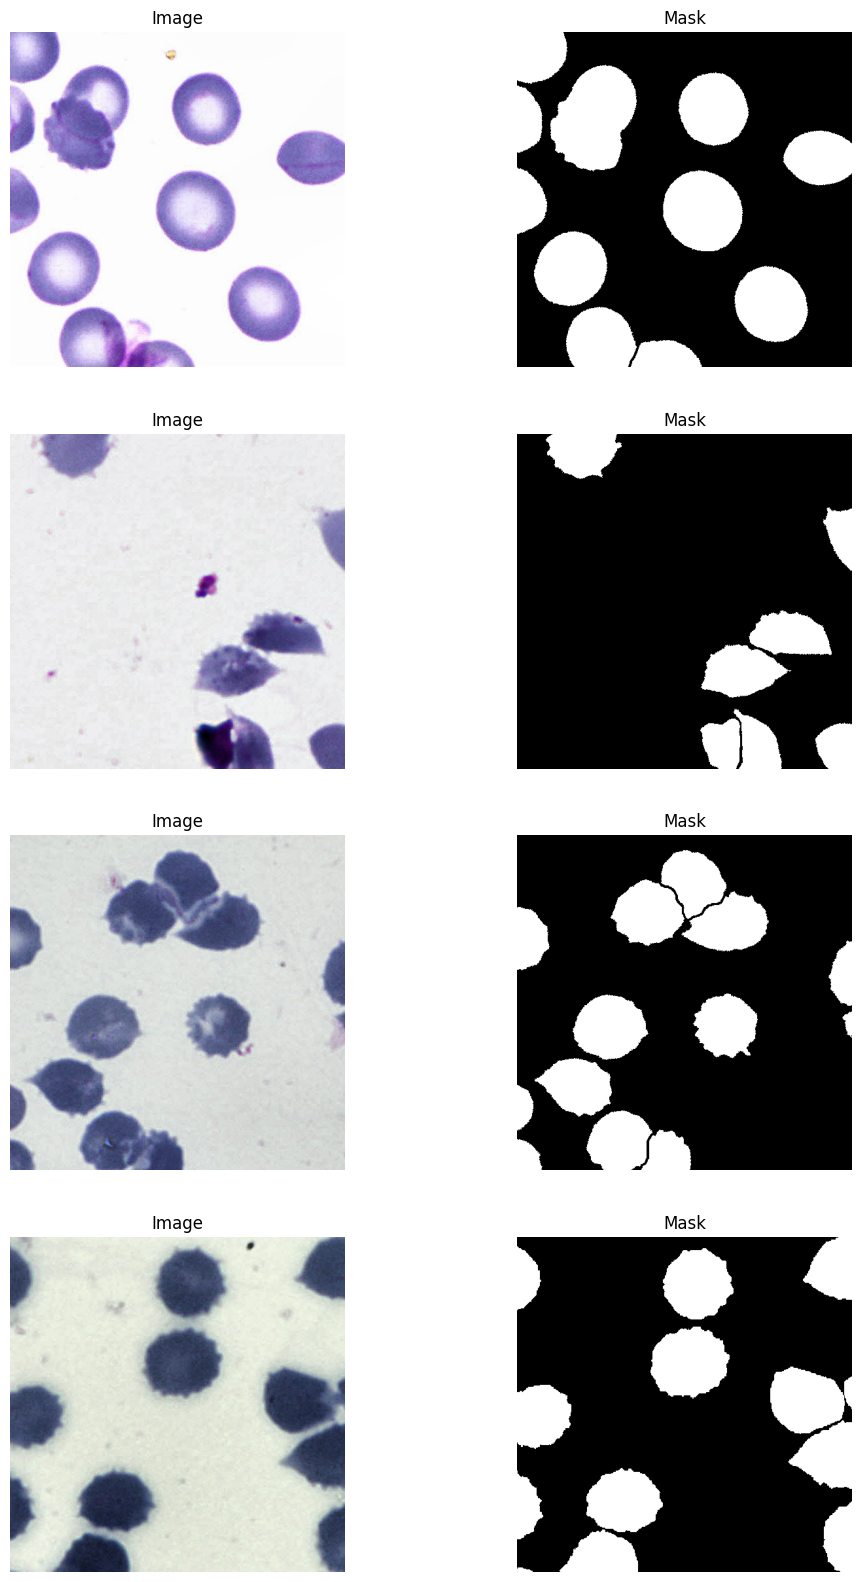

In [ ]:
display_images_and_masks(data_module.train_dataset, num_classes, num_pairs=4)

# FUNCTION LOSS

In [ ]:
class FocalDiceLoss(nn.Module):
    """
    Loss function class Focal Loss + Dice Loss
    """
    def __init__(self,
                 mode,
                 gamma=2.0,
                 alpha=None,
                 beta=5.0,
                 smooth=0.0,
                 ignore_index=-100):
        super(FocalDiceLoss, self).__init__()
        self.beta = beta
        self.dice_loss = smp.losses.DiceLoss(mode=mode, smooth=smooth, ignore_index=ignore_index)
        self.focal_loss = smp.losses.FocalLoss(mode=mode, gamma=gamma, alpha=alpha, ignore_index=ignore_index)

    def forward(self, y_pred, y_true):
        return self.beta*self.focal_loss(y_pred.contiguous(), y_true) + self.dice_loss(y_pred, y_true)

# TRAINING

In [ ]:
class ModelCompilation():
    def __init__(self,
                model,
                optimizer,
                criterion,
                metric,
                device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.metric = metric
        self.device = device
        
        # Initialize best validation error to infinity so improvements can be tracked
        self.best_val_loss = float('inf')

        # Dictionary for storing metrics across all epochs
        self.history = {
            "train_loss": [],
            "train_iou": [],
            "val_loss": [],
            "val_iou": [],
            "test_loss": [],
            "test_iou": [],
            "log": [],
        }

        # List for storing the model's predictions on the test
        self.mlp_preds = []

    # Training step on one epoch
    def train_step(self, dataloader):
        self.model.train()
        running_loss = 0.0
        running_iou = 0.0

        progress_bar = tqdm(dataloader, desc="Training", leave=False)
        for img, mask in progress_bar:
            img, mask = img.to(self.device), mask.to(self.device)

            self.optimizer.zero_grad()

            img_pred = self.model(img)
            img_pred = img_pred.sigmoid() # For binary segmentation we use sigmoid

            loss = self.criterion(img_pred, mask)
            loss.backward()
            self.optimizer.step()

            tp, fp, fn, tn = self.metric['confusion_matrix'](img_pred, mask.long(), mode='binary', threshold=0.5)
            iou_score = self.metric['iou-score'](tp, fp, fn, tn, reduction="micro")
            running_loss += loss.item() * img.size(0)
            running_iou += iou_score * img.size(0)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", IoU=f"{iou_score:.4f}")

        # Average final error and iou per training epoch
        train_loss = running_loss / len(dataloader.dataset)
        train_iou = running_iou  / len(dataloader.dataset)

        return train_loss, train_iou

    # Шаг валидации на одной эпохе
    def val_step(self, dataloader):
        self.model.eval()
        running_loss = 0.0
        running_iou = 0.0

        with torch.no_grad():
          progress_bar = tqdm(dataloader, desc="Validation", leave=False)
          for img, mask in progress_bar:
              img, mask = img.to(self.device), mask.to(self.device)

              img_pred = self.model(img)
              img_pred = img_pred.sigmoid() # For binary segmentation we use sigmoid

              loss = self.criterion(img_pred, mask)
              tp, fp, fn, tn = self.metric['confusion_matrix'](img_pred, mask.long(), mode='binary', threshold=0.5)
              iou_score = self.metric['iou-score'](tp, fp, fn, tn, reduction="micro")
              running_loss += loss.item() * img.size(0)
              running_iou += iou_score * img.size(0)

              progress_bar.set_postfix(loss=f"{loss.item():.4f}", IoU=f"{iou_score:.4f}")

        # Average final error and iou for validation
        val_loss = running_loss / len(dataloader.dataset)
        val_iou = running_iou  / len(dataloader.dataset)

        return val_loss, val_iou

    def test_step(self, dataloader):
        self.model.eval()
        running_loss = 0.0
        running_iou = 0.0

        with torch.no_grad():
          progress_bar = tqdm(dataloader, desc="Testing", leave=False)
          for img, mask in progress_bar:
              img, mask = img.to(self.device), mask.to(self.device)

              img_pred = self.model(img)
              img_pred = img_pred.sigmoid() # For binary segmentation we use sigmoid

              loss = self.criterion(img_pred, mask)
              tp, fp, fn, tn = self.metric['confusion_matrix'](img_pred, mask.long(), mode='binary', threshold=0.5)
              iou_score = self.metric['iou-score'](tp, fp, fn, tn, reduction="micro")
              running_loss += loss.item() * img.size(0)
              running_iou += iou_score * img.size(0)

              progress_bar.set_postfix(loss=f"{loss.item():.4f}", IoU=f"{iou_score:.4f}")

        # Average final error and iou for validation
        test_loss = running_loss / len(dataloader.dataset)
        test_iou = running_iou  / len(dataloader.dataset)

        return test_loss, test_iou

    def fit(self, train_dataloader, val_dataloader, epochs):
        for epoch in range(epochs):
            print(f"Epoch {epoch}/{epochs}")
            train_loss, train_iou = self.train_step(train_dataloader)
            val_loss, val_iou = self.val_step(val_dataloader)

            epoch_log_msg = f'Epoch {epoch}: train_loss: {train_loss:.4f} - train_iou: {train_iou:.4f} - val_loss: {val_loss:.4f} - val_iou: {val_iou:.4f} \n'
            print(epoch_log_msg)

            # Save the best model
            # If the current validation error is less than the previous one
            if val_loss < self.best_val_loss:
                val_log_msg = f"✔️ Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}. Saving weights... \n"
                print(val_log_msg)
                self.best_val_loss = val_loss # update the value of the best validation error
                torch.save(self.model.state_dict(), 'best_sgm_model.pth') # save model weights
            else:
                val_log_msg = f"❌ No improvement in validation loss. Best validation loss remains: {self.best_val_loss:.4f} \n"
                print(val_log_msg)

            # Save the metrics calculated in a given epoch to a dictionary
            self.history["train_loss"].append(train_loss)
            self.history["train_iou"].append(train_iou.detach().cpu().numpy())
            self.history["val_loss"].append(val_loss)
            self.history["val_iou"].append(val_iou.detach().cpu().numpy())
            self.history["log"].append(epoch_log_msg + val_log_msg)

            with open('train_loss.txt', 'a') as f:
                f.write(f'loss: {train_loss}\n')

            with open('val_loss.txt', 'a') as f:
                f.write(f'val_loss: {val_loss}\n')

            with open('train_iou.txt', 'a') as f:
                f.write(f'train_iou: {train_iou}\n')

            with open('val_iou.txt', 'a') as f:
                f.write(f'val_iou: {val_iou}\n')

        files.download('train_loss.txt')
        files.download('val_loss.txt')
        files.download('train_iou.txt')
        files.download('val_iou.txt')
        files.download('best_sgm_model.pth')

        return self.model

    def testing(self, test_loader, checkpoint_path):
        # Load the best saved model
        self.model.load_state_dict(torch.load(checkpoint_path))

        # Perform testing and display results
        test_loss, test_iou = self.test_step(test_loader)
        print(f'Test IoU: {test_iou:.4f}')

    def plot_metrics(self):
        epochs_range = range(1, len(self.history["train_loss"]) + 1)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 
        fig.patch.set_facecolor('#2a2d31')  

        for ax in axes:
            ax.set_facecolor('#2a2d31')  
            ax.spines['left'].set_color('#DAF7A6')
            ax.spines['bottom'].set_color('#DAF7A6')
            ax.tick_params(axis='both', which='both', labelcolor='#FFFFFF')

       # Error graph (Loss)
        axes[0].plot(epochs_range, self.history["train_loss"], label="Train Loss", color='#b7fed6')
        axes[0].plot(epochs_range, self.history["val_loss"], label="Validation Loss", color='#DAF7A6')
        axes[0].set_title("Ошибка модели", color='#FFFFFF')
        axes[0].set_xlabel("Эпохи", color='#FFFFFF')
        axes[0].set_ylabel("Loss", color='#FFFFFF')
        axes[0].legend()

        # IoU Graph
        axes[1].plot(epochs_range, self.history["train_iou"], label="Train IoU", color='#b7fed6')
        axes[1].plot(epochs_range, self.history["val_iou"], label="Validation IoU", color='#DAF7A6')
        axes[1].set_title("IoU модели", color='#FFFFFF')
        axes[1].set_xlabel("Эпохи", color='#FFFFFF')
        axes[1].set_ylabel("IoU", color='#FFFFFF')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def log(self):
        for i in self.history['log']:
            print(i)

In [ ]:
def testing_on_image(idx_img, color_palette=None):
    if color_palette is None:
        colors = plt.get_cmap('tab20').colors  # Select palette 'tab20' with 20 colors
        color_palette = torch.tensor((np.array(colors)[:num_classes] * 255).astype(np.uint8))  

    test_image = test_data[idx_img][0]
    y_mask = test_data[idx_img][1]

    model.eval().to(device)
    with torch.no_grad():
        # Get the predicted mask for the image
        predicted_mask = model(test_image[None, :].to(device))[0]

    predicted_mask = predicted_mask.cpu()

    # Process the predicted mask depending on the task
    if(predicted_mask.size(0)==1): 
        predicted_mask = predicted_mask.sigmoid()
        predicted_mask = (predicted_mask > 0.5).float().permute(1, 2, 0) 
        y_mask = y_mask.permute(1, 2, 0)
    else: # Для многоклассовой сегментации
        pred_mask = predicted_mask.softmax(dim=1) 
        predicted_mask = predicted_mask.argmax(axis=0) 
        y_mask = y_mask.argmax(axis=0) 
        y_mask = color_palette[y_mask]
        predicted_mask = color_palette[predicted_mask]

    fig, axes = plt.subplots(1, 3, figsize=(20, 15))

    # Display the original image
    axes[0].imshow(test_image.permute(1, 2, 0).numpy())
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display the true mask
    axes[1].imshow(y_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Display the predicted mask
    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 2
learning_rate = 0.0001

model = smp.FPN(encoder_name='mit_b2', encoder_weights='imagenet', classes=num_classes).to(device)
optimizer = Adam(params=model.parameters(), lr=learning_rate)
loss_function = FocalDiceLoss(mode='binary', gamma=2.0, alpha=None, beta=5.0, smooth=0.1)
metrics = {'confusion_matrix': smp.metrics.get_stats, 'iou-score': smp.metrics.iou_score}
scheduler = CosineAnnealingLR(optimizer, 1600)
model_compilation = ModelCompilation(model, optimizer, loss_function, metrics, device)

In [ ]:
model = model_compilation.fit(train_dataloader, val_dataloader, epochs)

Epoch 0/2


Epoch 0: train_loss: 1.2190 - train_iou: 0.8261 - val_loss: 1.1633 - val_iou: 0.9184 

✔️ Validation loss improved from inf to 1.1633. Saving weights... 

Epoch 1/2


Epoch 1: train_loss: 1.1728 - train_iou: 0.9069 - val_loss: 1.1553 - val_iou: 0.9191 

✔️ Validation loss improved from 1.1633 to 1.1553. Saving weights... 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FPN(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64,

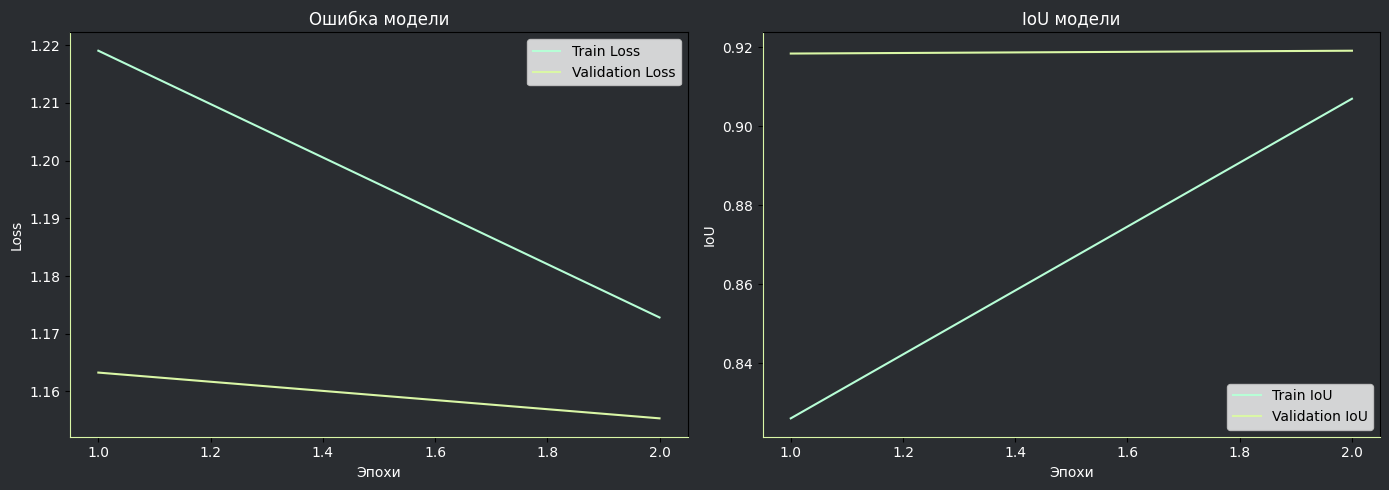

In [ ]:
model_compilation.plot_metrics()

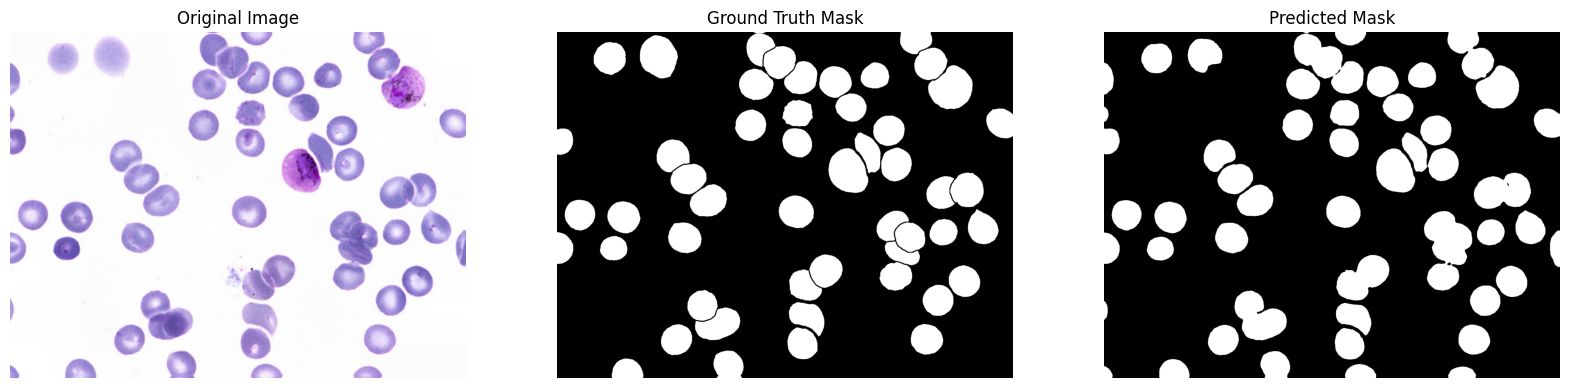

In [ ]:
testing_on_image(idx_img=5)